In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils_sparse import u_momentum, v_momentum, get_rhs, get_coeff_mat_modified, pres_correct, update_velocity, check_divergence_free
import scipy.sparse as sparse
from scipy.sparse import lil_matrix as zeros
import time
import sys
import dill as pickle
# These are the usual ipython objects, including this one you are creating
ipython_vars = ["In", "Out", "exit", "quit", "get_ipython", "ipython_vars"]

In [2]:
store_sparse = {}
for grid_size in range(2,8):
    beg = time.time()
    # Variable declaration
    imax = 2**grid_size                     # grid size in x-direction
    jmax = imax                       # grid size in y-direction
    max_iteration = 1000
    maxRes = 1000
    # iteration = 10
    mu = 0.01                        # viscosity
    rho = 1                          # density
    velocity = 1                     # velocity = lid velocity
    dx = 1 / (imax - 1)              # dx, dy cell sizes along x and y directions
    dy = 1 / (jmax - 1)
    x = np.arange(dx / 2, 1 + dx/2 - dx / 2, dx)
    y = np.arange(0, 1+dy/2, dy)
    alphaP = 0.1                     # pressure under-relaxation
    alphaU = 0.7                     # velocity under-relaxation
    tol = 1e-5
    p = zeros((imax, jmax))             # p = Pressure
    p_star = zeros((imax, jmax))
    p_prime = zeros((imax, jmax))       # pressure correction
    rhsp = zeros((imax, jmax))          # Right hand side vector of pressure correction equation
    divergence = zeros((imax, jmax))
    
    # Vertical velocity
    v_star = zeros((imax, jmax + 1))
    vold = zeros((imax, jmax + 1))
    vRes = zeros((imax, jmax + 1))
    v = zeros((imax, jmax + 1))
    d_v = zeros((imax, jmax + 1))       # velocity correction coefficient
    
    # Horizontal Velocity
    u_star = zeros((imax + 1, jmax))
    uold = zeros((imax + 1, jmax))
    uRes = zeros((imax + 1, jmax))
    u = zeros((imax + 1, jmax))
    d_u = zeros((imax + 1, jmax))       # velocity correction coefficient
    # Boundary condition
    # Lid velocity (Top wall is moving with 1m/s)
    u_star[:, jmax-1] = velocity
    u[:, jmax-1] = velocity
    iteration = 1
    # max_iteration = 1
    while iteration <= max_iteration and maxRes > tol:
        iteration += 1
        u_star, d_u = u_momentum(imax, jmax, dx, dy, rho, mu, u, v, p_star, velocity, alphaU)
        v_star, d_v = v_momentum(imax, jmax, dx, dy, rho, mu, u, v, p_star, alphaU)
    
        uold = u.copy()
        vold = v.copy()
    
        rhsp = get_rhs(imax, jmax, dx, dy, rho, u_star, v_star)
        Ap = get_coeff_mat_modified(imax, jmax, dx, dy, rho, d_u, d_v)
        p, p_prime = pres_correct(imax, jmax, rhsp, Ap, p_star, alphaP)
        u, v = update_velocity(imax, jmax, u_star, v_star, p_prime, d_u, d_v, velocity)
        divergence = check_divergence_free(imax, jmax, dx, dy, u, v)
    
        p_star = p.copy()
    
        vRes = np.abs(v - vold)
        uRes = np.abs(u - uold)
        maxRes_u = np.max(uRes)
        maxRes_v = np.max(vRes)
        maxRes = max(maxRes_u, maxRes_v)
    
        if maxRes > 2:
            print("not going to converge!")
            break
    duration = time.time() - beg
    print(f"Final Iteration = {iteration}; Final Res = {maxRes}")
    #cond = sparse.linalg.cond(Ap)
    #stability = sparse.linalg.norm(np.linalg.solve(Ap.todense(), rhsp)-sparse.linalg.spsolve(Ap, rhsp))
    # Get a sorted list of the objects and their sizes
    mem = {
        key: value
        for key, value in sorted(
            [
                (x, sys.getsizeof(globals().get(x)))
                for x in dir()
                if not x.startswith("_") and x not in sys.modules and x not in ipython_vars
            ],
            key=lambda x: x[1],
            reverse=True,
        )
    }
    mem_usage = sum(mem.values()) / 1e6
    store_sparse.update({imax:{'runtime':duration,'mem':mem_usage}})

/home/bgard3/anaconda3/envs/CFD/lib/python3.8/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Final Iteration = 124; Final Res = 9.764946173082371e-06
Final Iteration = 172; Final Res = 9.85310095704935e-06
Final Iteration = 164; Final Res = 9.896423402849797e-06
Final Iteration = 561; Final Res = 9.979850154551162e-06
Final Iteration = 1001; Final Res = 5.780008458650121e-05
Final Iteration = 1001; Final Res = 0.00017968565718134988


In [4]:
store_sparse

{4: {'runtime': 1.9328515529632568, 'mem': 0.003964},
 8: {'runtime': 10.142037868499756, 'mem': 0.006492},
 16: {'runtime': 40.97033643722534, 'mem': 0.00662},
 32: {'runtime': 600.9010853767395, 'mem': 0.006876},
 64: {'runtime': 5559.375804901123, 'mem': 0.007388},
 128: {'runtime': 40044.52940130234, 'mem': 0.008412}}

In [3]:
pickle.dump(store_sparse,open('Resource_Usage_UpTo_7_sparse.p','wb'))

In [6]:
dense = pickle.load(open('Resource_Usage_UpTo_7.p','rb'))

Text(0, 0.5, 'Resources Used')

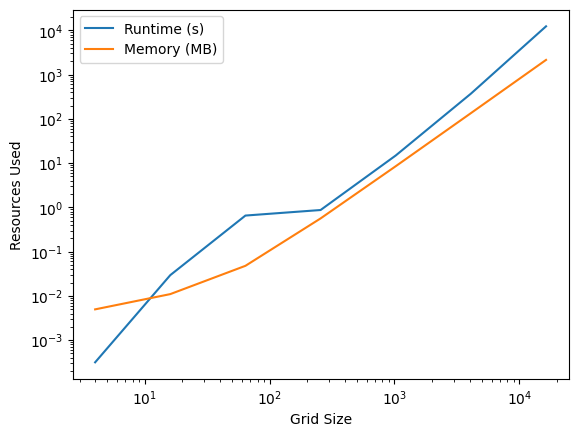

In [25]:
plt.loglog([(i)**2 for i in store_results.keys()],[list(store_results.values())[i]['runtime'] for i in range(len(store_results))],label='Runtime (s)')
plt.loglog([(i)**2 for i in store_results.keys()],[list(store_results.values())[i]['mem'] for i in range(len(store_results))],label='Memory (MB)')
plt.legend()
plt.xlabel("Grid Size")
plt.ylabel('Resources Used')